In [118]:
import tensorflow as tf

import numpy as np
import scipy.sparse as scs
from scipy.stats import multinomial
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt


import umap as um
#from sklearn.linear_model import Lasso
#import itertools 

from os import listdir
from os.path import isfile, join

import random


from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import os
import pickle

from plot_results import get_dbl_metrics

from sklearn.preprocessing import StandardScaler


import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import mmread


In [119]:
#- origionally copied from vae.py
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

def define_clust_vae(enc_sze, ngens, num_clust, LR=1e-3):
    
    tfk  = tf.keras
    tfkl = tf.keras.layers
    tfpl = tfp.layers
    tfd  = tfp.distributions

    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)
    
    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tfkl.Dense(256, activation='relu'),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[0])),
        tfkl.BatchNormalization(),
        tfkl.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[1])),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
        )
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tfkl.Dense(256, activation='relu'),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[2])),
        tfkl.BatchNormalization(),
        tfkl.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seeds[3])),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')

    clust_classifier = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tfkl.BatchNormalization(),
        tfkl.Dense(num_clust, activation='sigmoid')#, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
    ], name='clust_classifier')
    
    IPT     = tfk.Input(shape = ngens)
    z       = encoder(IPT)
    OPT1    = decoder(z)
    OPT2    = clust_classifier(z)

    vae = tfk.Model(inputs=[IPT],
                      outputs=[OPT1, OPT2])
    
    def nll(x, rv_x): 
        rec = rv_x.log_prob(x)
        return -tf.math.reduce_sum(rec, axis=-1) 
    
    vae.compile(optimizer = tf.optimizers.Adamax(learning_rate=LR),#Adam, 1e-3
                  loss=[nll, 'categorical_crossentropy'], loss_weights=[1,10000])
  
    #1e-3
    return vae


def plt_loss(hist):
    x = np.arange(len(hist.history['loss']))
    keysv = list(hist.history.keys())
    
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(20,5))

    plt.subplot(1, 4, 1)
    plt.plot(x, np.array(hist.history['loss']), label='loss')
    plt.plot(x, np.array(hist.history['val_loss']), label='val_loss')
    plt.title('total loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 4, 2)
    plt.plot(x, np.array(hist.history['decoder_loss']), label='decoder_loss')
    plt.plot(x, np.array(hist.history['val_decoder_loss']), label='val_decoder_loss')
    plt.title('vae loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
                     
    plt.subplot(1, 4, 3)
    plt.plot(x, np.array(hist.history['clust_classifier_loss']), label='clust_classifier_loss')
    plt.plot(x, np.array(hist.history['val_clust_classifier_loss']), label='val_clust_classifier_loss')
    plt.title('classifier loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 4, 4)
    plt.plot(x, np.array(hist.history['lr']), label='lr')
    plt.title('Learning Rate')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('LR')
  
    



In [120]:
data_dirs = ['sce_normalized_data_inflate', 'sce_normalized_data_sum', 'sce_normalized_data_avg']
data_dirs = ['sce_normalized_data_inflate']

In [121]:
seeds = [42, 29503, 432809, 42, 132975, 9231996, 12883823, 9231996, 1234, 62938, 57203 ,109573, 23]

In [126]:
#HYPERPARAMS
eps  = 1000#40#100
enc_sze = 5#8#7
use_old=False
save=True
estimate_doublets=True
extra_figs=True

'''norm_method = 'log_scale_cells'
pat = 20
LR=1e-3
num_layers = 2
sze_layers = 256'''


#norm_methods = ['log_scale_cells', 'log_scale_cells', 'log']
pats = [10]
LRs= [1e-3]
enc_szes = [5]
#pats = [10]
#LRs= [1e-3]
#enc_szes = [5]
hvg_method = 'hvg'
clust_weight = 10000



norm_method = 'log_scale_cells'
num_layer = 2
sze_layer = 256




In [127]:
from sklearn.model_selection import train_test_split


In [128]:
path = '../data/' + data_dir + '/'
files = [f for f in listdir(path) if (isfile(join(path, f)) & (f[-18:-4] == 'real_logcounts'))]
files = np.sort(files)
files

array(['HEK-HMEC-MULTI_real_logcounts.mtx',
       'HMEC-orig-MULTI_real_logcounts.mtx',
       'HMEC-rep-MULTI_real_logcounts.mtx', 'J293t-dm_real_logcounts.mtx',
       'cline-ch_real_logcounts.mtx', 'hm-12k_real_logcounts.mtx',
       'hm-6k_real_logcounts.mtx', 'mkidney-ch_real_logcounts.mtx',
       'nuc-MULTI_real_logcounts.mtx', 'pbmc-1A-dm_real_logcounts.mtx',
       'pbmc-1B-dm_real_logcounts.mtx', 'pbmc-1C-dm_real_logcounts.mtx',
       'pbmc-2ctrl-dm_real_logcounts.mtx',
       'pbmc-2stim-dm_real_logcounts.mtx', 'pbmc-ch_real_logcounts.mtx',
       'pdx-MULTI_real_logcounts.mtx'], dtype='<U34')

In [129]:
files[7:8]

array(['mkidney-ch_real_logcounts.mtx'], dtype='<U34')

HEK-HMEC-MULTI
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HEK-HMEC-MULTI
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HEK-HMEC-MULTI
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HEK-HMEC-MULTI_
generating new VAE encoding
Epoch 1/1000
315/315 [==============================] - 4s 7ms/step - loss: 115107.7029 - decoder_loss: 91300.0781 - clust_classifier_loss: 2.3703 - val_loss: 77095.0000 - val_decoder_loss: 58904.1797 - val_clust_classifier_loss: 1.8035
Epoch 2/1000
315/315 [==============================] - 2s 5ms/step - loss: 76537.7859 - decoder_loss: 58997.1510 - clust_classifier_loss: 1.7397 - val_loss: 61453.8

<Figure size 432x288 with 0 Axes>

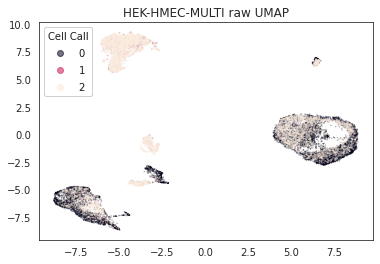

<Figure size 432x288 with 0 Axes>

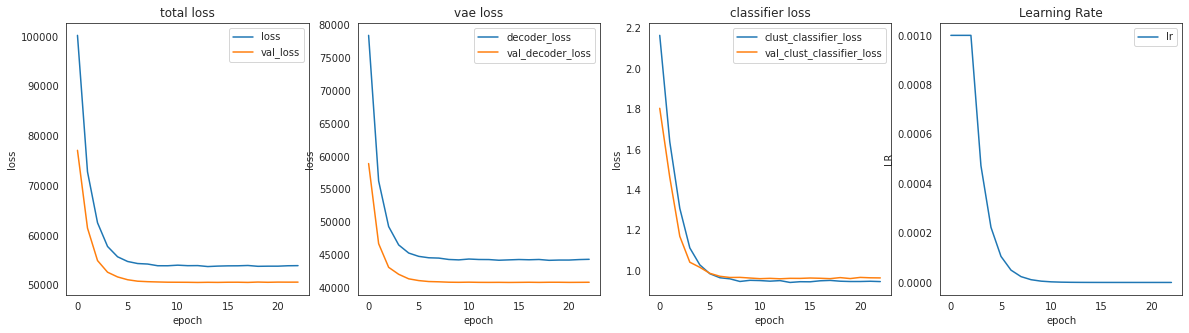

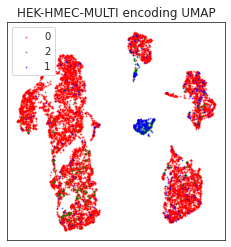

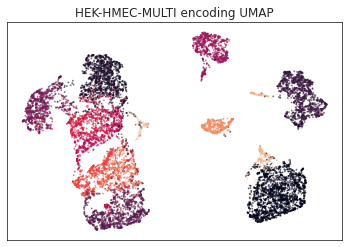

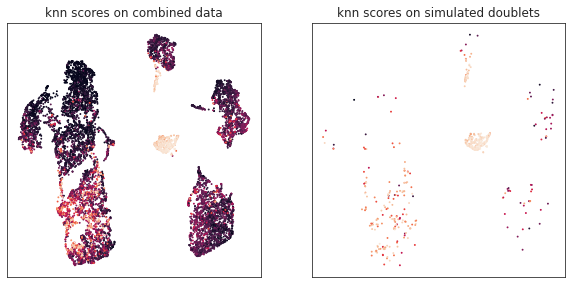

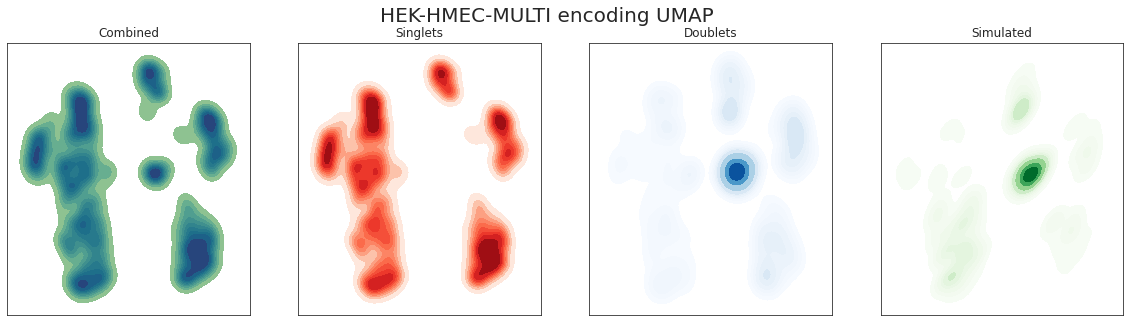

HMEC-orig-MULTI
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HMEC-orig-MULTI
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HMEC-orig-MULTI
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HMEC-orig-MULTI_
generating new VAE encoding
Epoch 1/1000
812/812 [==============================] - 6s 6ms/step - loss: 95843.9602 - decoder_loss: 76329.1861 - clust_classifier_loss: 1.9400 - val_loss: 54609.8516 - val_decoder_loss: 43317.5078 - val_clust_classifier_loss: 1.1143
Epoch 2/1000
812/812 [==============================] - 5s 6ms/step - loss: 56373.5854 - decoder_loss: 45895.1444 - clust_classifier_loss: 1.0337 - val_loss: 4702

<Figure size 432x288 with 0 Axes>

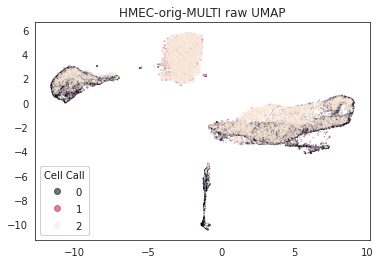

<Figure size 432x288 with 0 Axes>

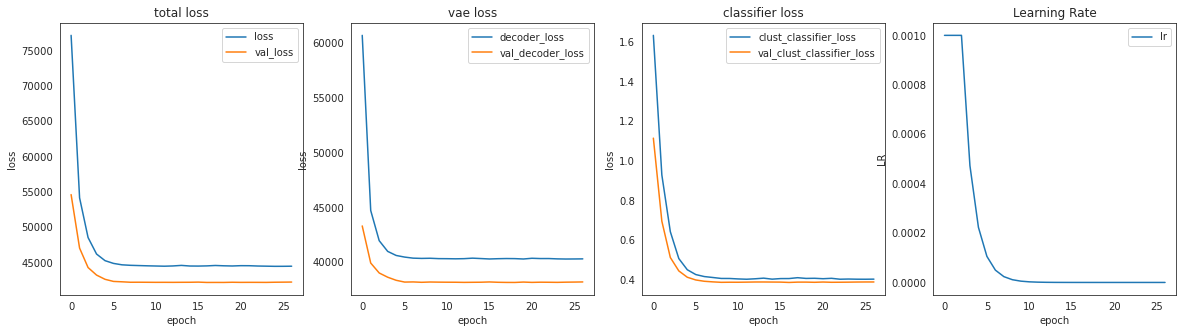

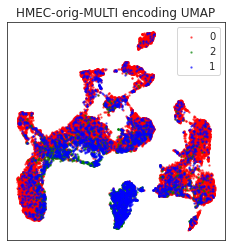

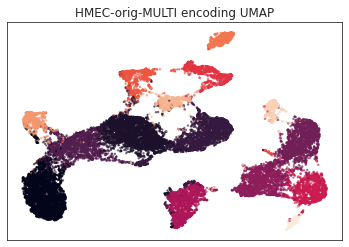

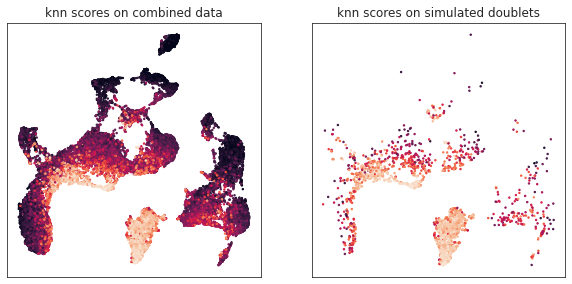

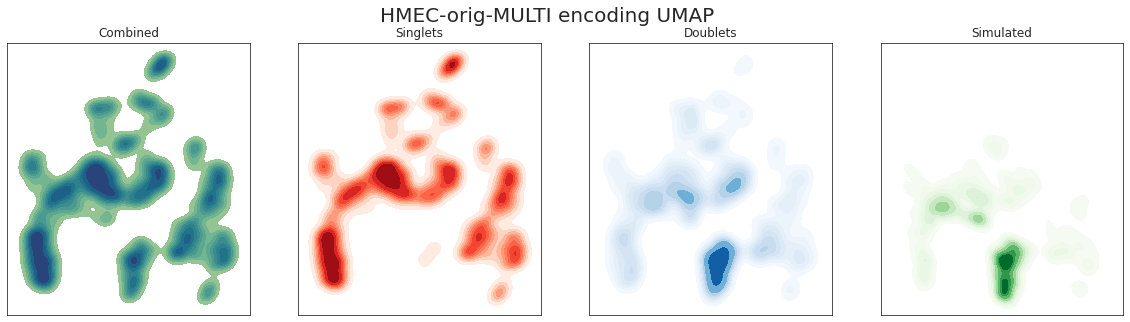

HMEC-rep-MULTI
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HMEC-rep-MULTI
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HMEC-rep-MULTI
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_HMEC-rep-MULTI_
generating new VAE encoding
Epoch 1/1000
323/323 [==============================] - 3s 6ms/step - loss: 117916.1631 - decoder_loss: 99438.0332 - clust_classifier_loss: 1.8434 - val_loss: 71854.9375 - val_decoder_loss: 58512.4727 - val_clust_classifier_loss: 1.3249
Epoch 2/1000
323/323 [==============================] - 1s 5ms/step - loss: 72795.2554 - decoder_loss: 60300.0177 - clust_classifier_loss: 1.2406 - val_loss: 63276.6

<Figure size 432x288 with 0 Axes>

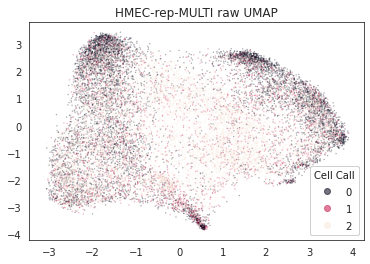

<Figure size 432x288 with 0 Axes>

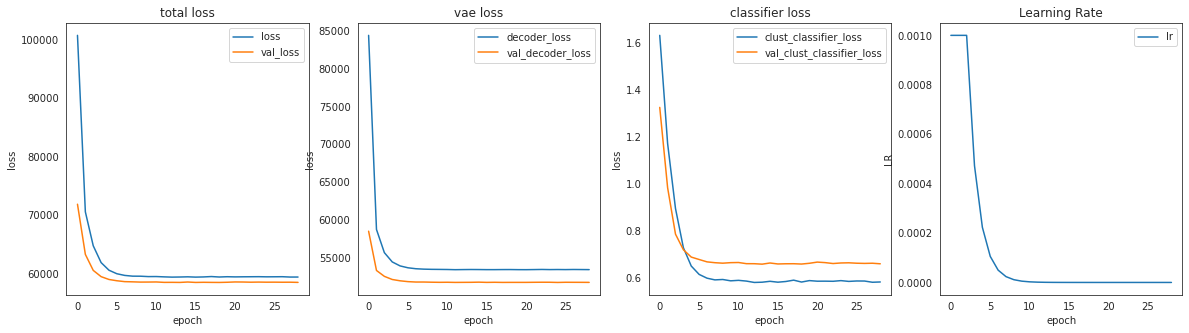

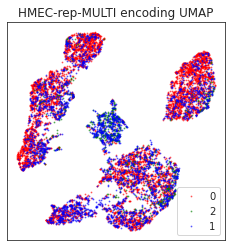

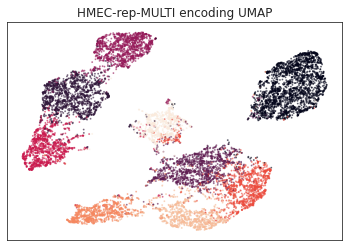

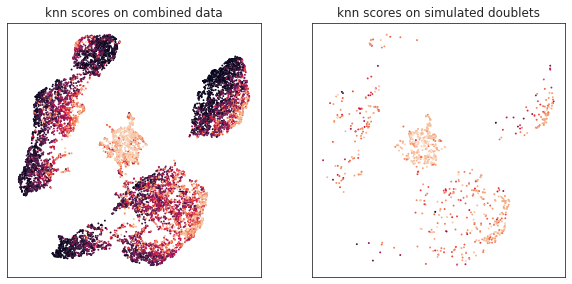

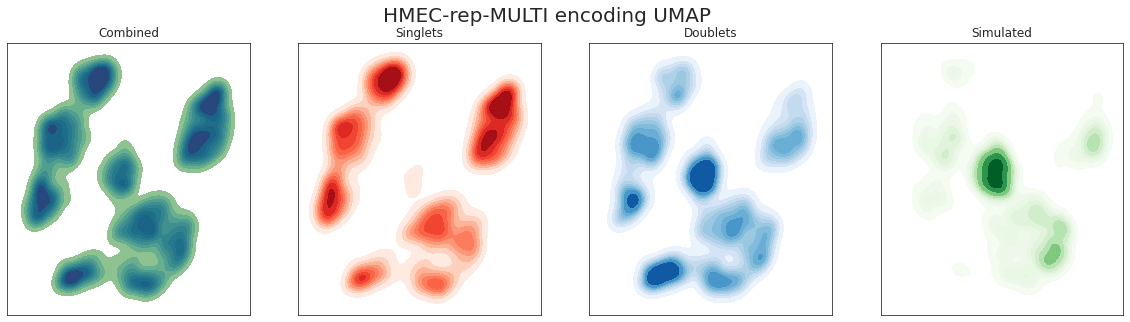

J293t-dm
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_J293t-dm
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_J293t-dm
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_J293t-dm_
generating new VAE encoding
Epoch 1/1000
15/15 [==============================] - 2s 33ms/step - loss: 137382.4194 - decoder_loss: 119841.4053 - clust_classifier_loss: 1.7505 - val_loss: 103505.1094 - val_decoder_loss: 87943.7188 - val_clust_classifier_loss: 1.5465
Epoch 2/1000
15/15 [==============================] - 0s 9ms/step - loss: 117931.8354 - decoder_loss: 104806.7275 - clust_classifier_loss: 1.3044 - val_loss: 98051.7656 - val_decoder_loss:

<Figure size 432x288 with 0 Axes>

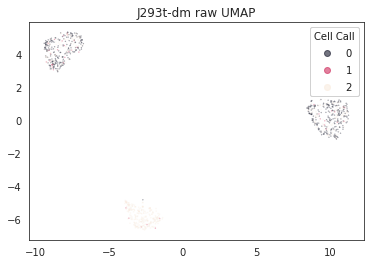

<Figure size 432x288 with 0 Axes>

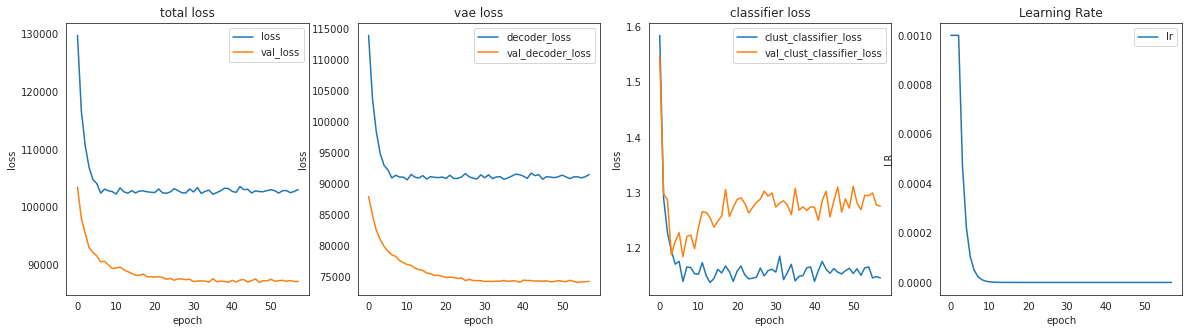

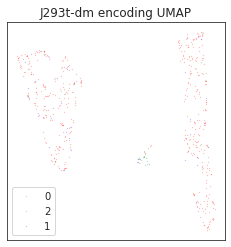

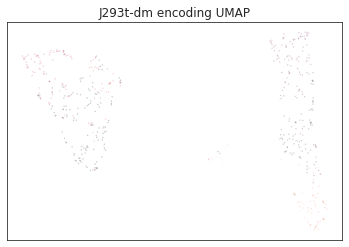

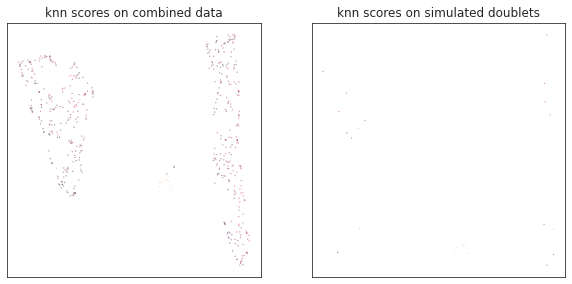

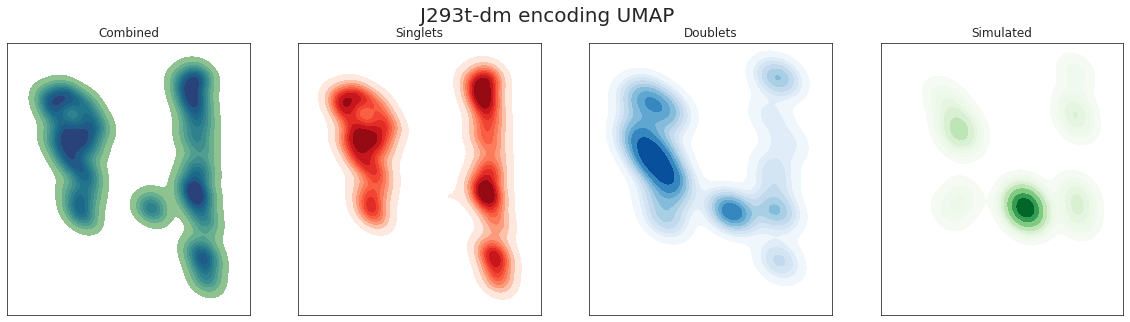

cline-ch
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_cline-ch
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_cline-ch
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_cline-ch_
generating new VAE encoding
Epoch 1/1000
235/235 [==============================] - 3s 7ms/step - loss: 120119.5411 - decoder_loss: 97715.9477 - clust_classifier_loss: 2.2293 - val_loss: 84616.7500 - val_decoder_loss: 68483.0625 - val_clust_classifier_loss: 1.5928
Epoch 2/1000
235/235 [==============================] - 1s 6ms/step - loss: 87355.0386 - decoder_loss: 70864.0742 - clust_classifier_loss: 1.6316 - val_loss: 74638.1875 - val_decoder_loss: 

<Figure size 432x288 with 0 Axes>

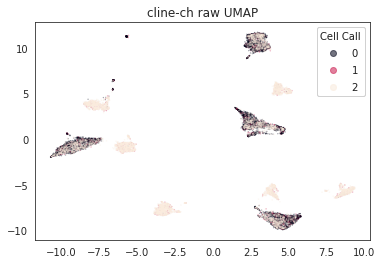

<Figure size 432x288 with 0 Axes>

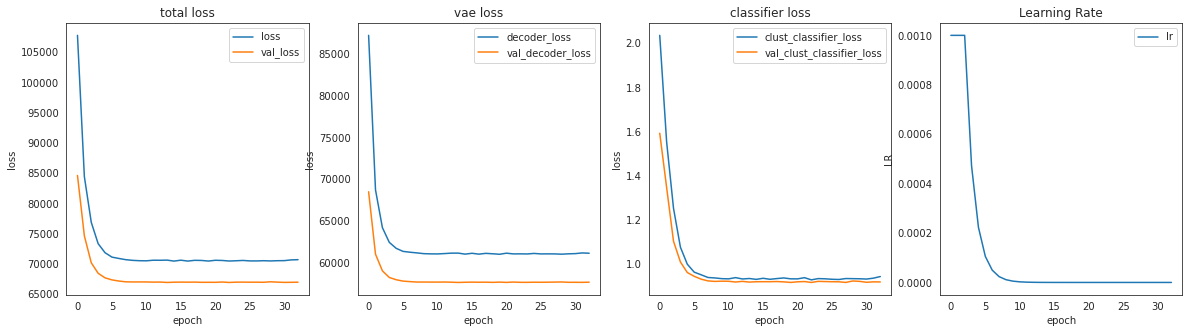

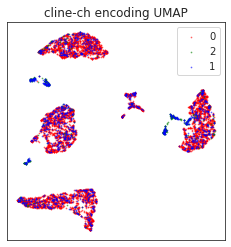

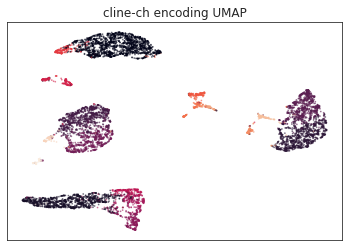

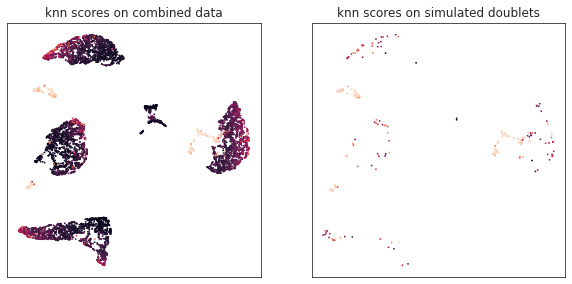

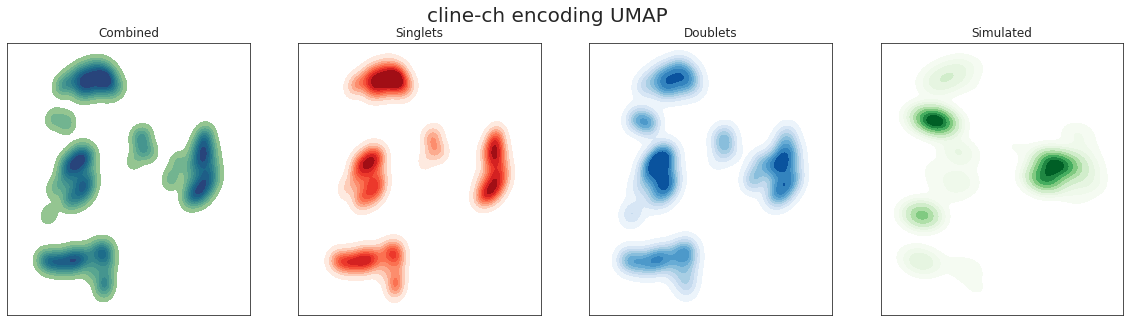

hm-12k
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_hm-12k
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_hm-12k
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_hm-12k_
generating new VAE encoding
Epoch 1/1000
386/386 [==============================] - 4s 6ms/step - loss: 107394.2315 - decoder_loss: 85907.0941 - clust_classifier_loss: 2.1360 - val_loss: 69175.1484 - val_decoder_loss: 53877.9570 - val_clust_classifier_loss: 1.5150
Epoch 2/1000
386/386 [==============================] - 2s 5ms/step - loss: 70841.6328 - decoder_loss: 56317.8036 - clust_classifier_loss: 1.4368 - val_loss: 57773.8750 - val_decoder_loss: 46398.16

<Figure size 432x288 with 0 Axes>

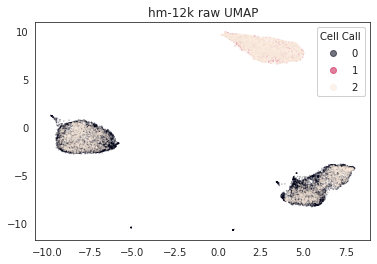

<Figure size 432x288 with 0 Axes>

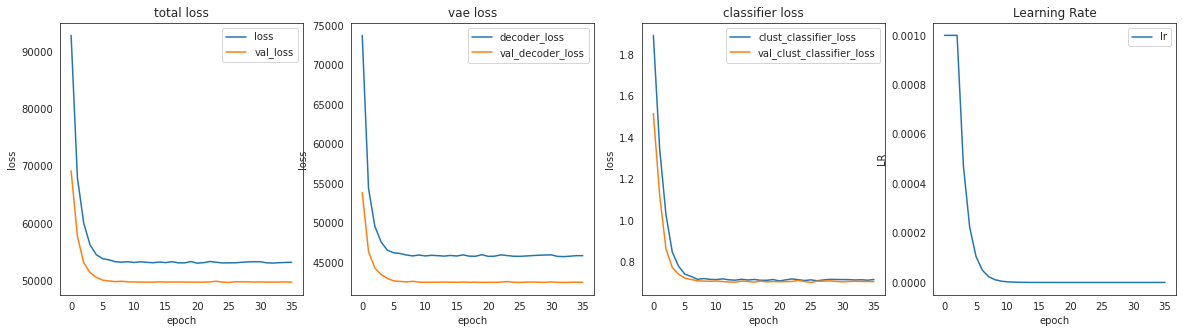

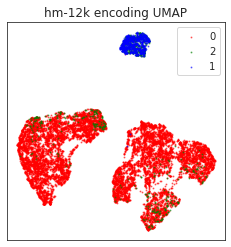

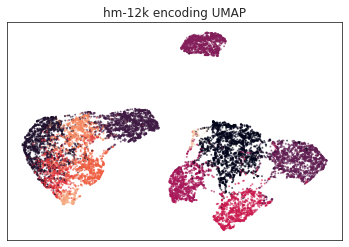

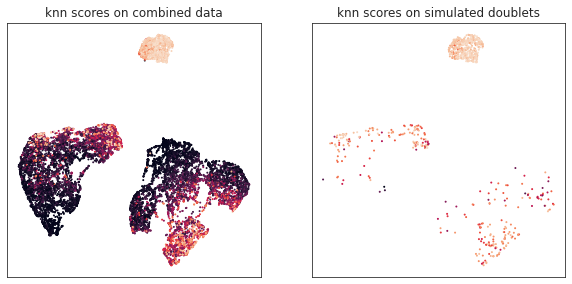

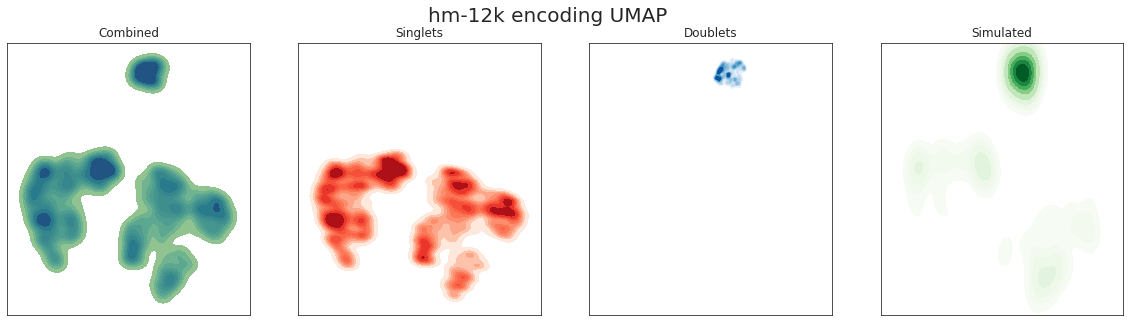

hm-6k
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_hm-6k
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_hm-6k
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_hm-6k_
generating new VAE encoding
Epoch 1/1000
201/201 [==============================] - 3s 7ms/step - loss: 112993.6161 - decoder_loss: 92181.9146 - clust_classifier_loss: 2.0694 - val_loss: 81238.4141 - val_decoder_loss: 65830.7891 - val_clust_classifier_loss: 1.5226
Epoch 2/1000
201/201 [==============================] - 1s 5ms/step - loss: 80153.1704 - decoder_loss: 64247.9231 - clust_classifier_loss: 1.5736 - val_loss: 62316.8125 - val_decoder_loss: 48988.1797 -

<Figure size 432x288 with 0 Axes>

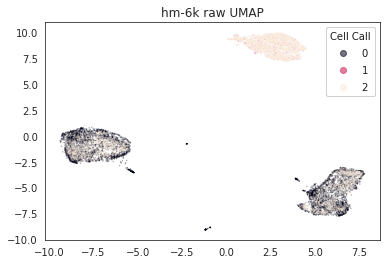

<Figure size 432x288 with 0 Axes>

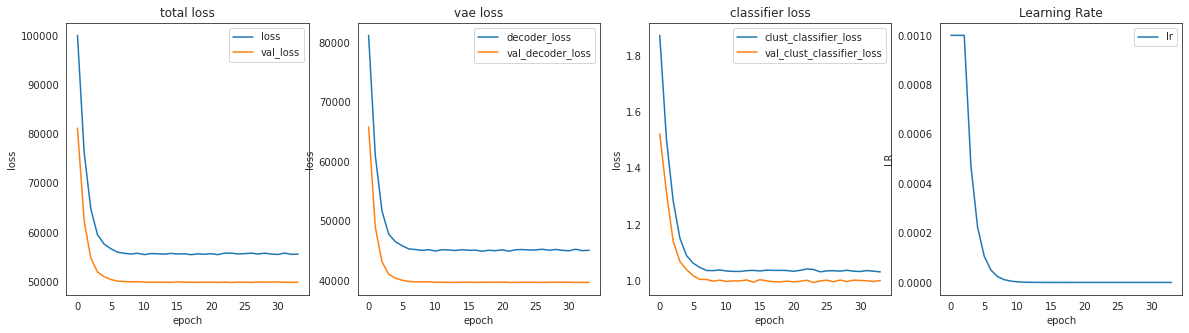

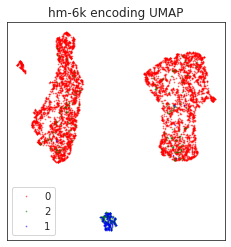

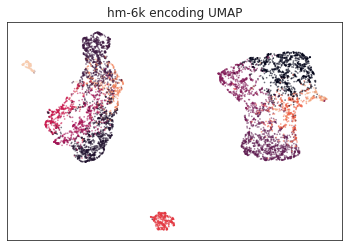

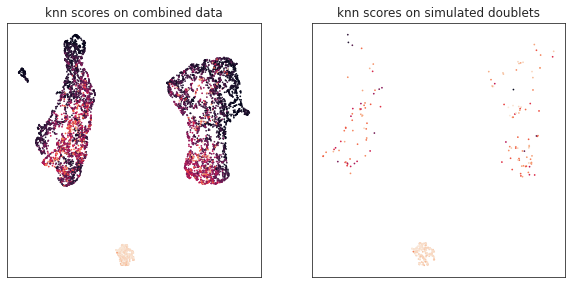

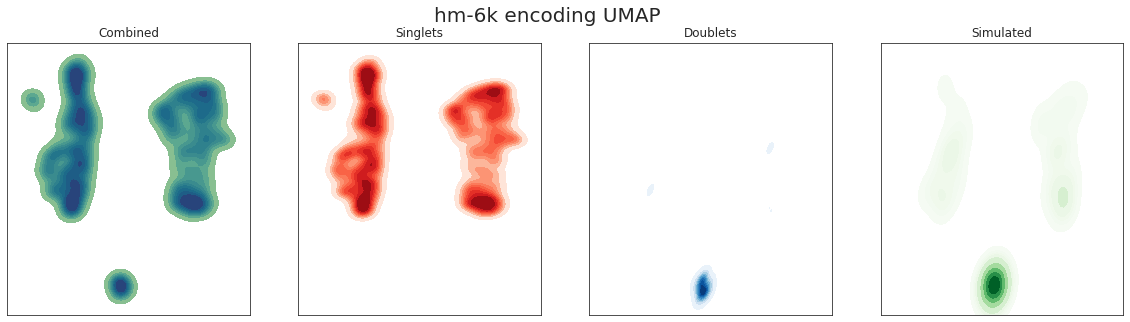

mkidney-ch
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_mkidney-ch
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_mkidney-ch
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_mkidney-ch_
generating new VAE encoding
Epoch 1/1000
674/674 [==============================] - 6s 6ms/step - loss: 107601.1291 - decoder_loss: 82017.7022 - clust_classifier_loss: 2.5429 - val_loss: 71923.8672 - val_decoder_loss: 53976.2969 - val_clust_classifier_loss: 1.7724
Epoch 2/1000
674/674 [==============================] - 4s 6ms/step - loss: 73917.5704 - decoder_loss: 57021.5901 - clust_classifier_loss: 1.6678 - val_loss: 63192.0938 - val_decode

<Figure size 432x288 with 0 Axes>

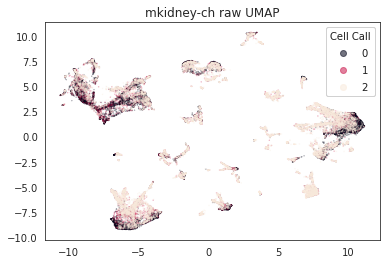

<Figure size 432x288 with 0 Axes>

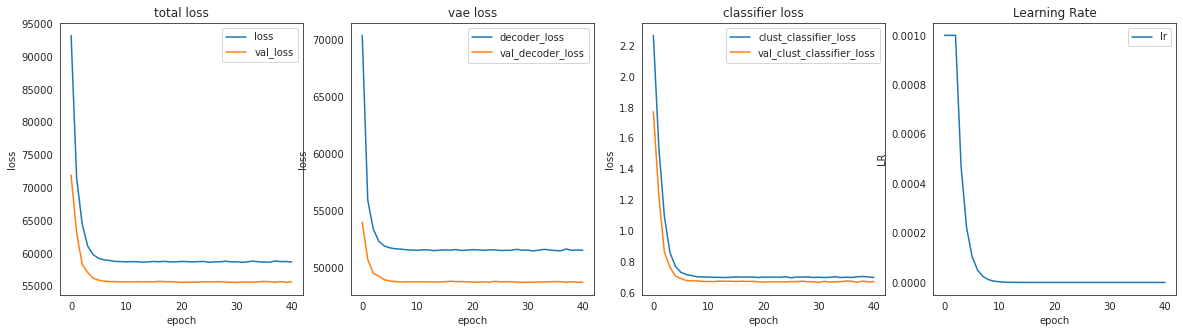

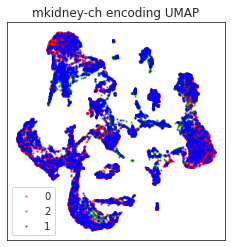

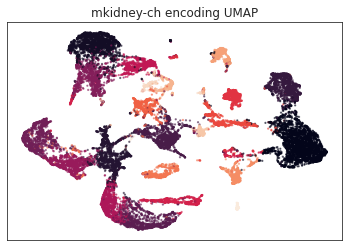

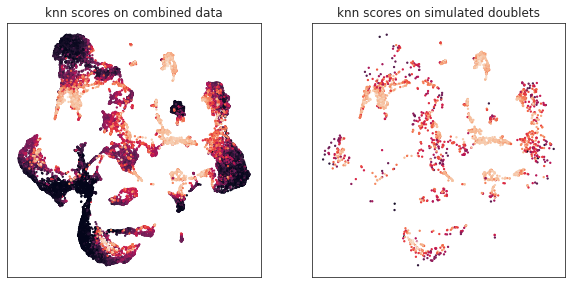

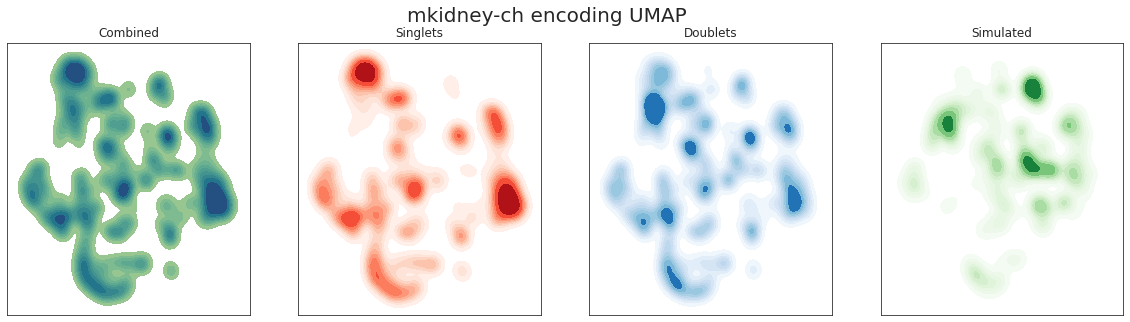

nuc-MULTI
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_nuc-MULTI
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_nuc-MULTI
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_nuc-MULTI_
generating new VAE encoding
Epoch 1/1000
176/176 [==============================] - 3s 7ms/step - loss: 125833.0949 - decoder_loss: 105468.6688 - clust_classifier_loss: 2.0287 - val_loss: 98832.8125 - val_decoder_loss: 83159.8438 - val_clust_classifier_loss: 1.5527
Epoch 2/1000
176/176 [==============================] - 1s 6ms/step - loss: 103186.4968 - decoder_loss: 87205.2685 - clust_classifier_loss: 1.5842 - val_loss: 88437.0000 - val_decoder_

<Figure size 432x288 with 0 Axes>

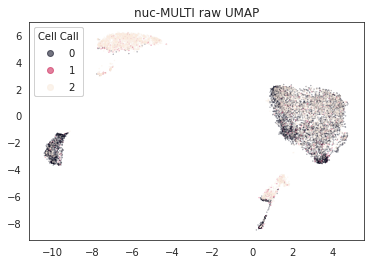

<Figure size 432x288 with 0 Axes>

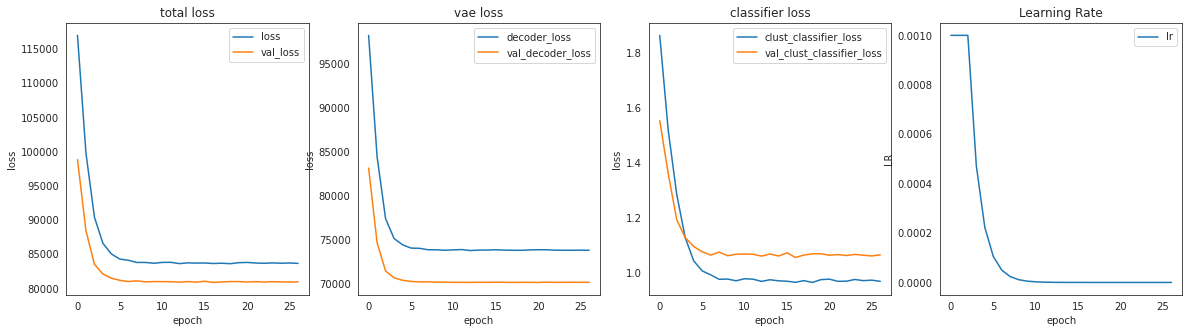

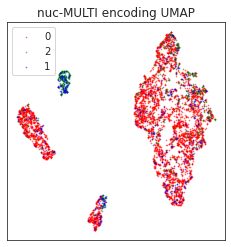

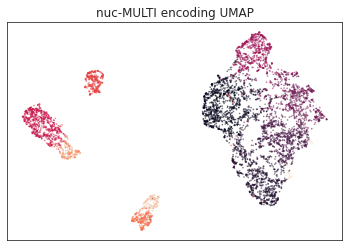

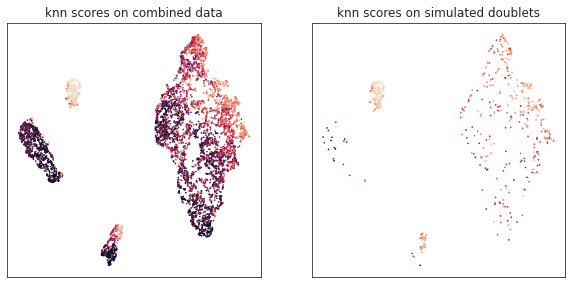

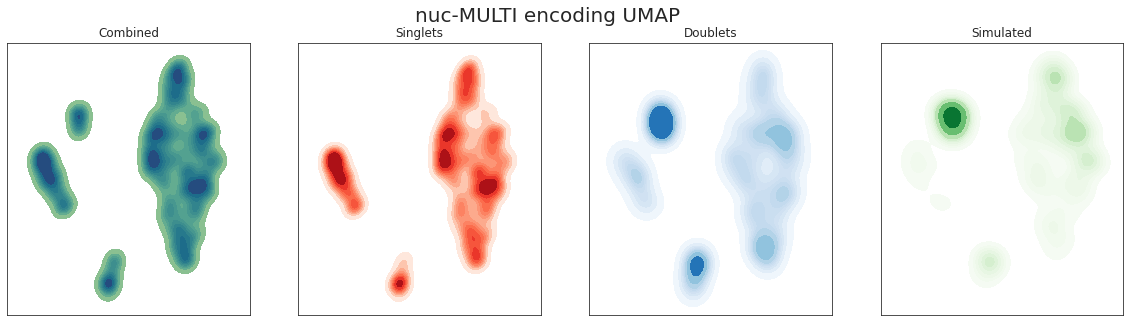

pbmc-1A-dm
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1A-dm
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1A-dm
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1A-dm_
generating new VAE encoding
Epoch 1/1000
98/98 [==============================] - 3s 10ms/step - loss: 131210.4309 - decoder_loss: 110748.9036 - clust_classifier_loss: 2.0427 - val_loss: 100725.8359 - val_decoder_loss: 86782.6172 - val_clust_classifier_loss: 1.3872
Epoch 2/1000
98/98 [==============================] - 1s 6ms/step - loss: 101861.9409 - decoder_loss: 87349.5709 - clust_classifier_loss: 1.4436 - val_loss: 83550.0312 - val_decode

<Figure size 432x288 with 0 Axes>

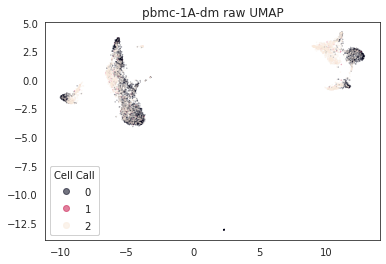

<Figure size 432x288 with 0 Axes>

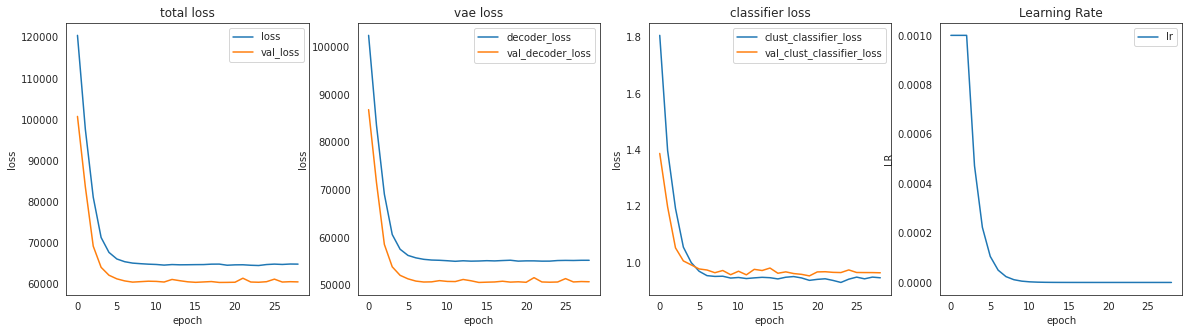

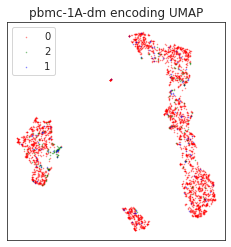

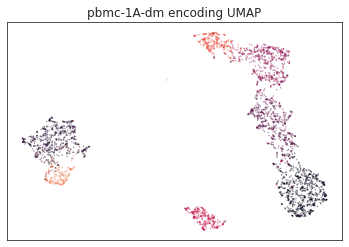

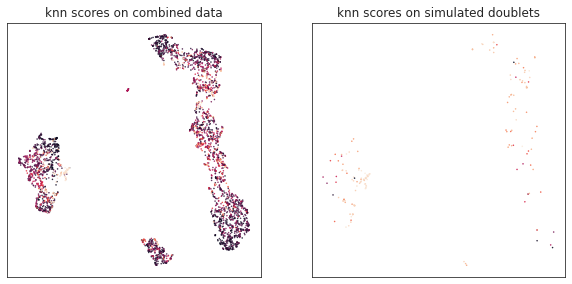

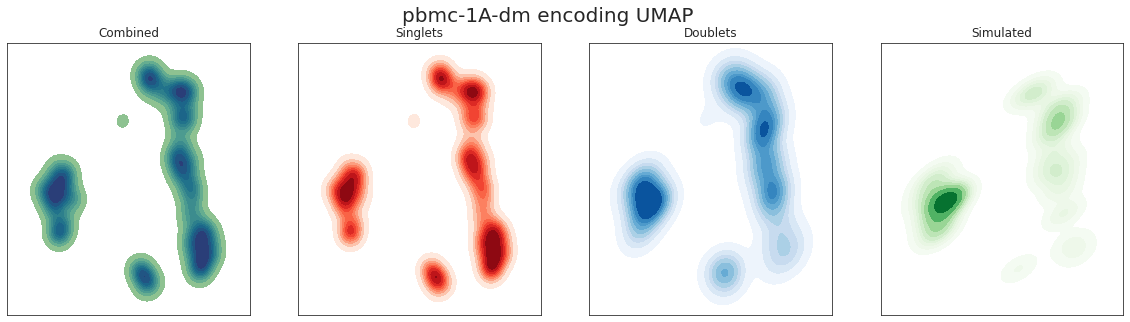

pbmc-1B-dm
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1B-dm
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1B-dm
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1B-dm_
generating new VAE encoding
Epoch 1/1000
113/113 [==============================] - 3s 9ms/step - loss: 127954.3860 - decoder_loss: 109515.8037 - clust_classifier_loss: 1.8401 - val_loss: 96089.6797 - val_decoder_loss: 82518.2031 - val_clust_classifier_loss: 1.3473
Epoch 2/1000
113/113 [==============================] - 1s 6ms/step - loss: 96859.2261 - decoder_loss: 84078.8331 - clust_classifier_loss: 1.2698 - val_loss: 74450.5234 - val_decod

<Figure size 432x288 with 0 Axes>

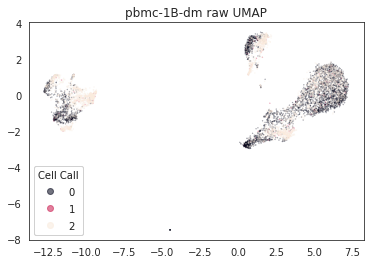

<Figure size 432x288 with 0 Axes>

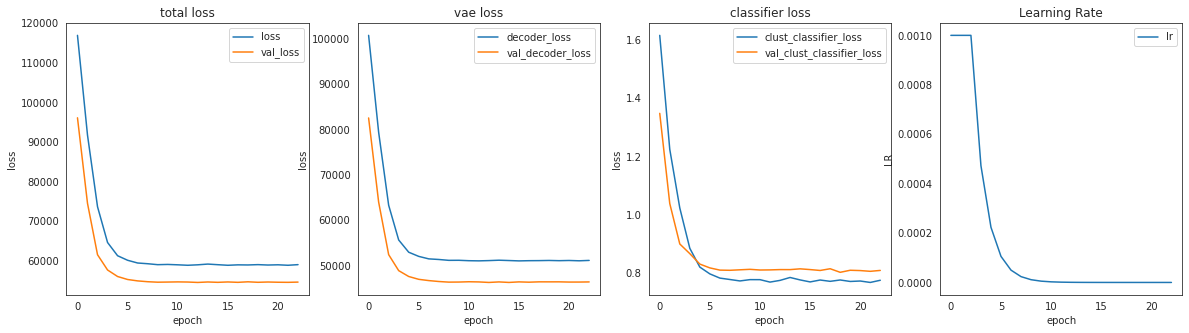

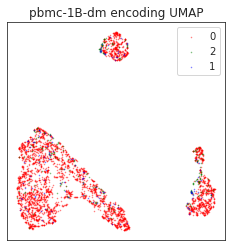

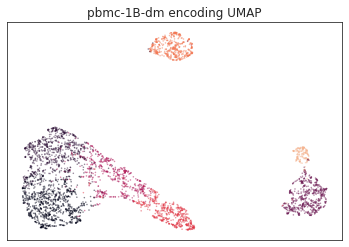

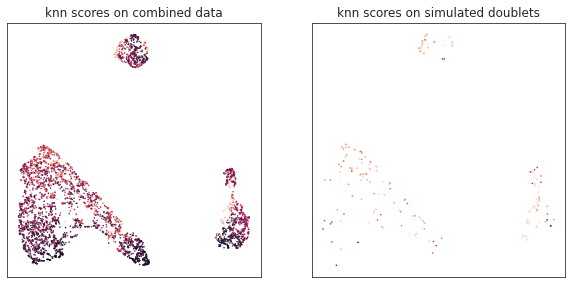

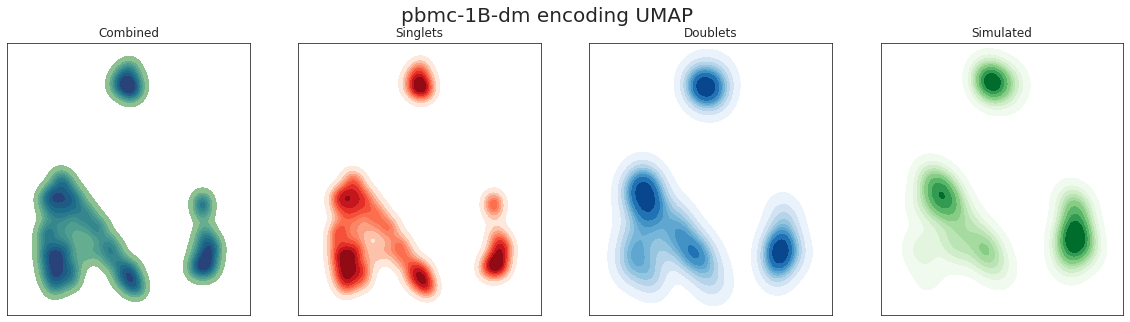

pbmc-1C-dm
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1C-dm
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1C-dm
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-1C-dm_
generating new VAE encoding
Epoch 1/1000
159/159 [==============================] - 4s 8ms/step - loss: 122758.4603 - decoder_loss: 104322.6806 - clust_classifier_loss: 1.8377 - val_loss: 88140.5391 - val_decoder_loss: 75315.2734 - val_clust_classifier_loss: 1.2719
Epoch 2/1000
159/159 [==============================] - 1s 6ms/step - loss: 85841.2919 - decoder_loss: 73003.6503 - clust_classifier_loss: 1.2729 - val_loss: 64120.9805 - val_decod

<Figure size 432x288 with 0 Axes>

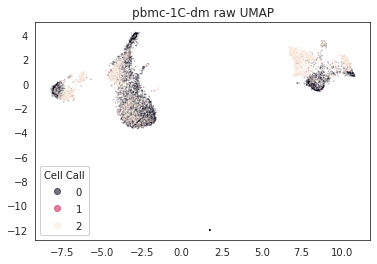

<Figure size 432x288 with 0 Axes>

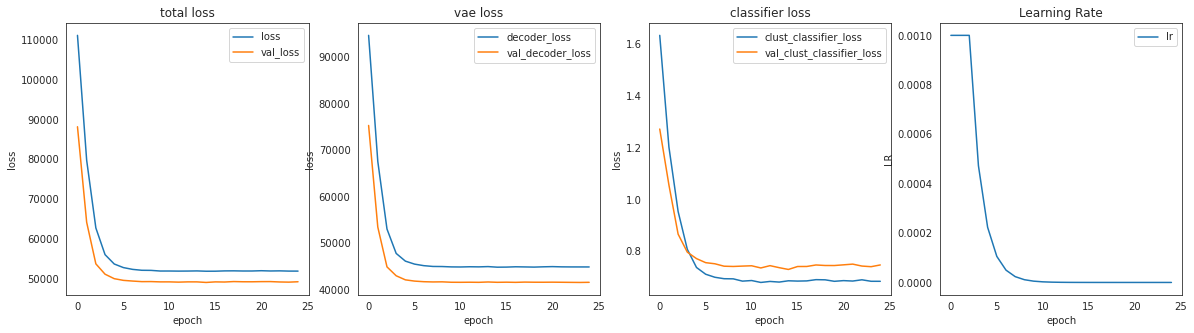

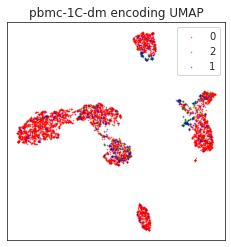

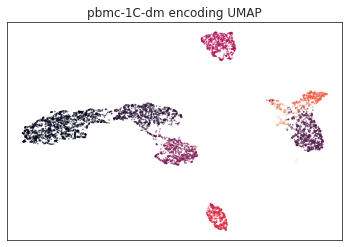

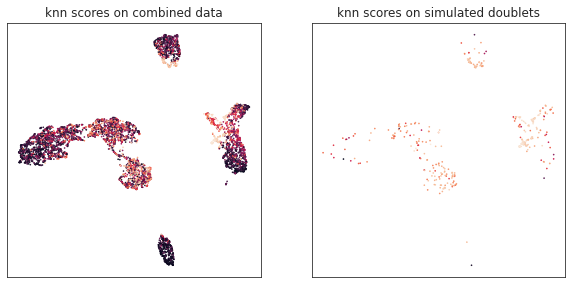

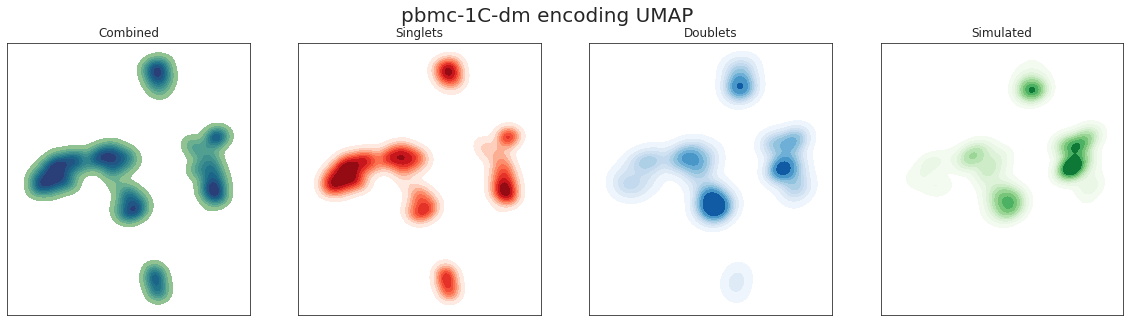

pbmc-2ctrl-dm
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-2ctrl-dm
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-2ctrl-dm
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-2ctrl-dm_
generating new VAE encoding
Epoch 1/1000
430/430 [==============================] - 4s 6ms/step - loss: 110168.7111 - decoder_loss: 90824.7525 - clust_classifier_loss: 1.9232 - val_loss: 67503.6094 - val_decoder_loss: 54315.4141 - val_clust_classifier_loss: 1.3041
Epoch 2/1000
430/430 [==============================] - 2s 5ms/step - loss: 69753.1011 - decoder_loss: 56853.8828 - clust_classifier_loss: 1.2753 - val_loss: 57859.5898 

<Figure size 432x288 with 0 Axes>

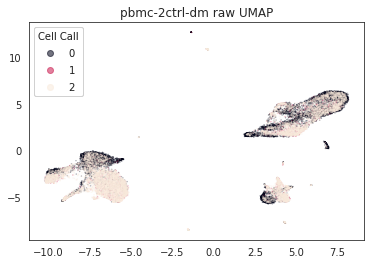

<Figure size 432x288 with 0 Axes>

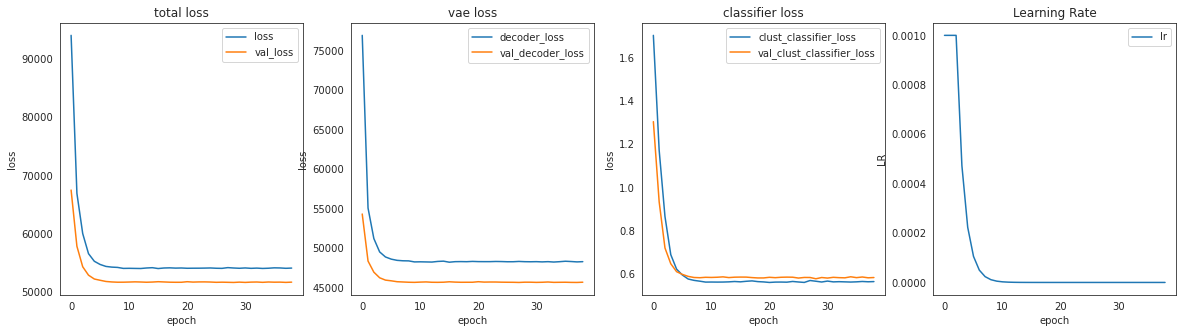

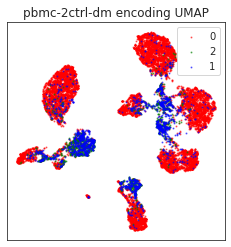

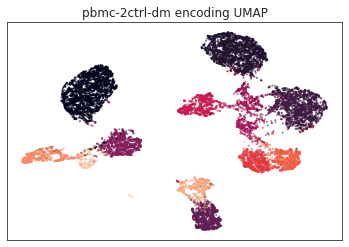

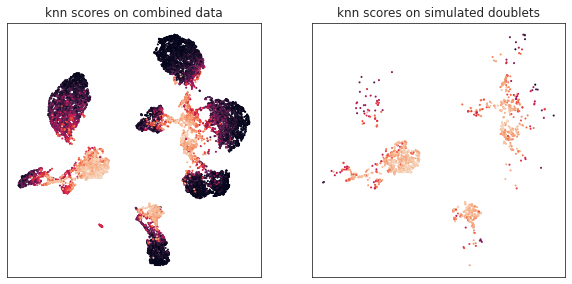

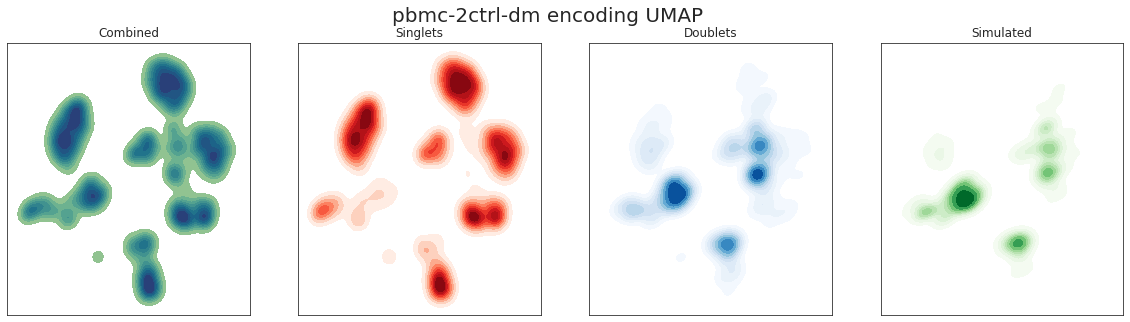

pbmc-2stim-dm
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-2stim-dm
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-2stim-dm
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-2stim-dm_
generating new VAE encoding
Epoch 1/1000
428/428 [==============================] - 4s 6ms/step - loss: 110669.7031 - decoder_loss: 89589.8134 - clust_classifier_loss: 2.0975 - val_loss: 66340.9688 - val_decoder_loss: 52717.2539 - val_clust_classifier_loss: 1.3476
Epoch 2/1000
428/428 [==============================] - 2s 5ms/step - loss: 68064.3559 - decoder_loss: 55067.1088 - clust_classifier_loss: 1.2852 - val_loss: 55771.4805 

<Figure size 432x288 with 0 Axes>

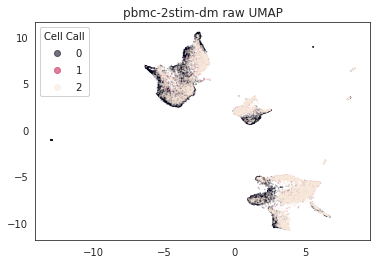

<Figure size 432x288 with 0 Axes>

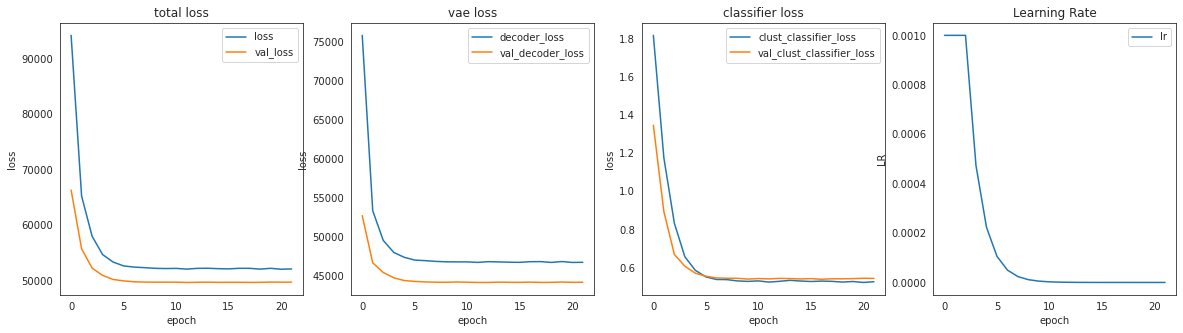

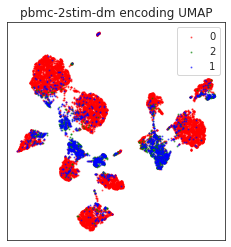

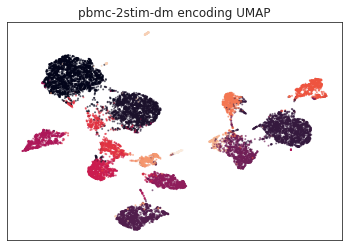

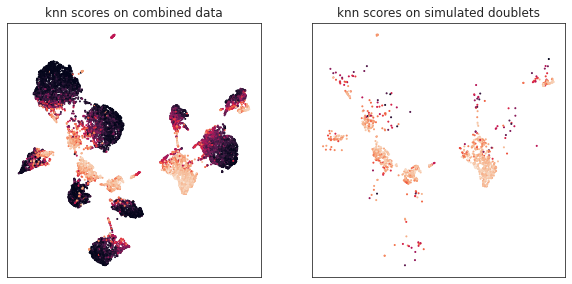

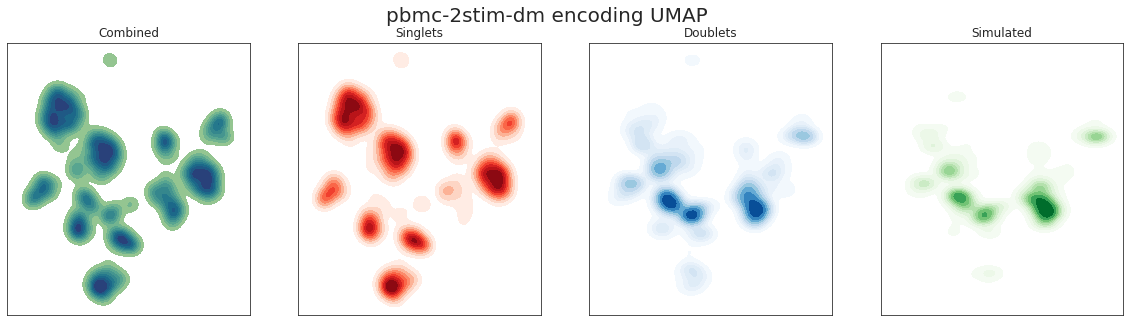

pbmc-ch
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-ch
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-ch
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pbmc-ch_
generating new VAE encoding
Epoch 1/1000
471/471 [==============================] - 5s 6ms/step - loss: 110529.2824 - decoder_loss: 92590.0534 - clust_classifier_loss: 1.7870 - val_loss: 63215.7930 - val_decoder_loss: 52537.3359 - val_clust_classifier_loss: 1.0559
Epoch 2/1000
471/471 [==============================] - 3s 5ms/step - loss: 65496.4546 - decoder_loss: 55330.1485 - clust_classifier_loss: 1.0046 - val_loss: 56296.6484 - val_decoder_loss: 4895

<Figure size 432x288 with 0 Axes>

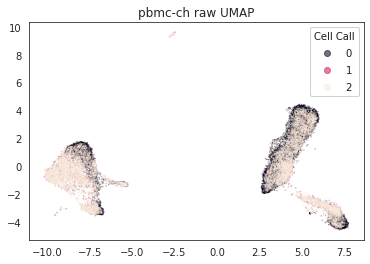

<Figure size 432x288 with 0 Axes>

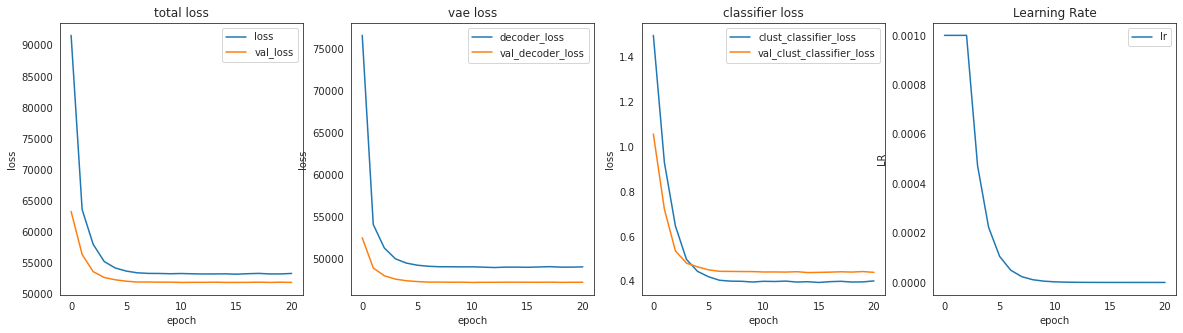

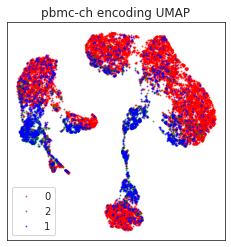

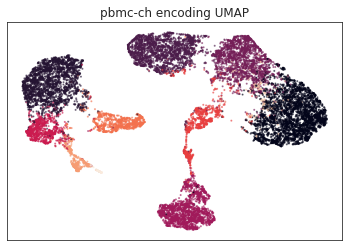

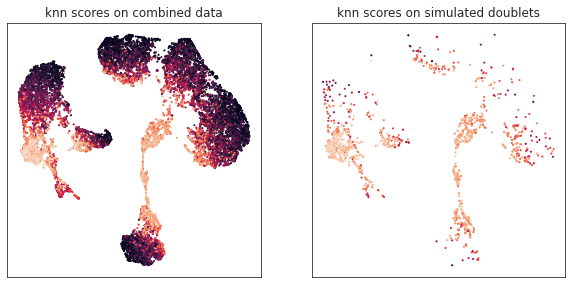

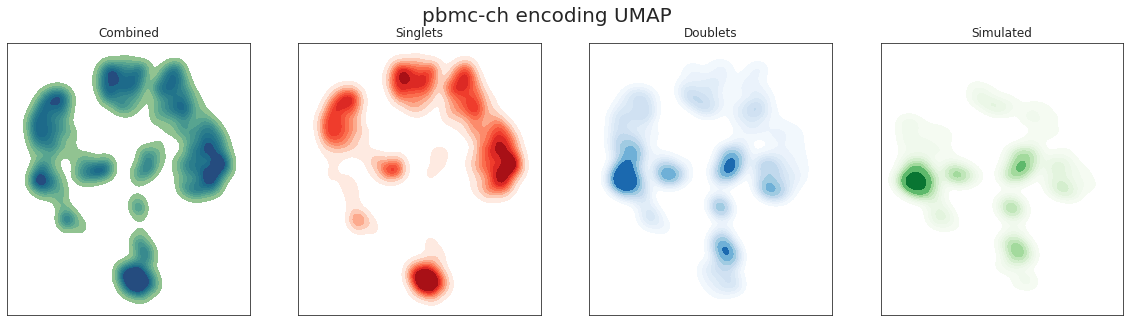

pdx-MULTI
log_scale_cells
CLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue
../data/sce_normalized_data_inflate/vae_embeddings/vae_embeddingCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pdx-MULTI
../data/sce_normalized_data_inflate/vae_embeddings/umapCLUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pdx-MULTI
../results_vae/sce_normalized_data_inflate/LUST10000_HVGhvg_EncSze5_Patience10_LR0.001_NumLayers2_SizeLayers256_EstDoubsTrue_pdx-MULTI_
generating new VAE encoding
Epoch 1/1000
325/325 [==============================] - 4s 6ms/step - loss: 120489.2698 - decoder_loss: 97257.9639 - clust_classifier_loss: 2.3142 - val_loss: 82189.0156 - val_decoder_loss: 65141.2227 - val_clust_classifier_loss: 1.6880
Epoch 2/1000
325/325 [==============================] - 2s 5ms/step - loss: 83920.0981 - decoder_loss: 66533.9677 - clust_classifier_loss: 1.7224 - val_loss: 71986.4453 - val_decoder_lo

<Figure size 432x288 with 0 Axes>

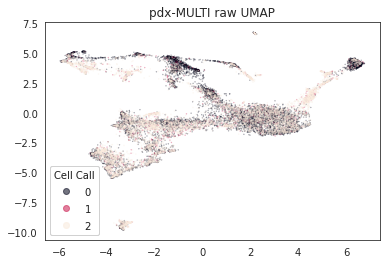

<Figure size 432x288 with 0 Axes>

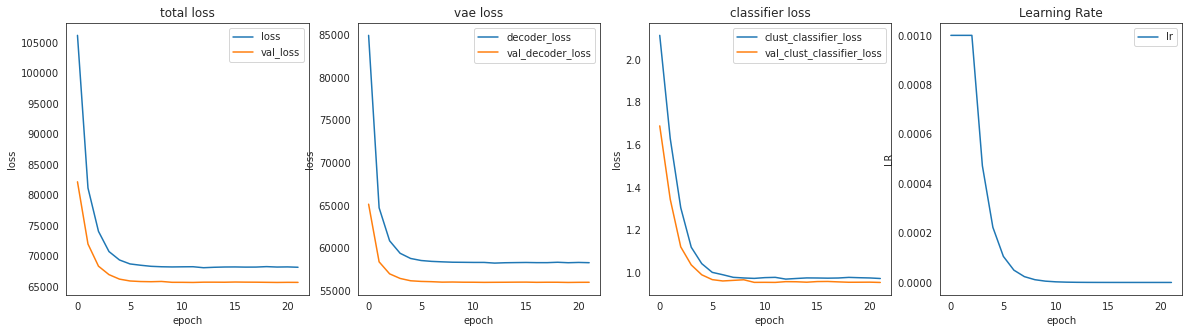

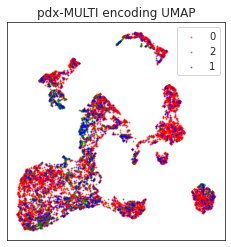

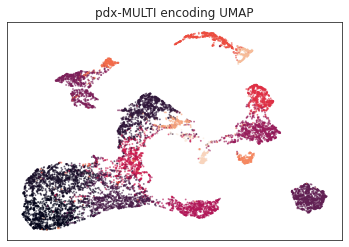

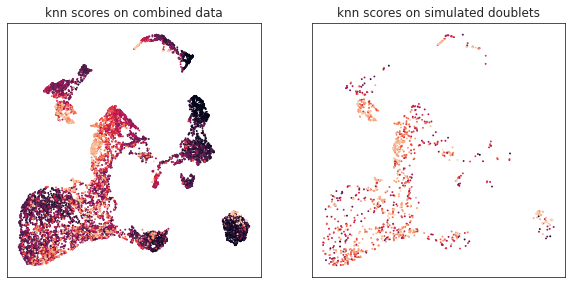

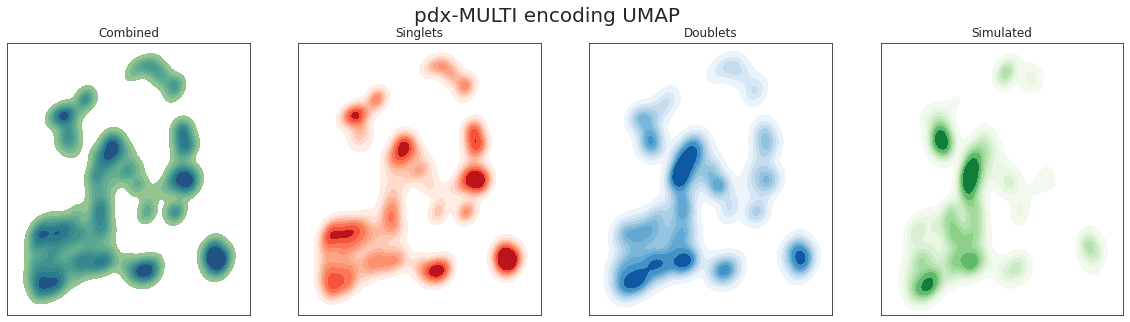

In [130]:
for data_dir in data_dirs:
    
    path = '../data/' + data_dir + '/'
    files = [f for f in listdir(path) if (isfile(join(path, f)) & (f[-18:-4] == 'real_logcounts'))]
    files = np.sort(files)
    #files=files[7:8]
    
    for file in files:

        data_name = file[:-19]

        print(data_name)    

        #scvae-dbl-btch/data/sce_normalized_data_inflate/pdx-MULTI_real_logcounts.mtx
        real_path = '../data/'+ data_dir + '/' + data_name + '_real_counts.mtx'
        sim_path = '../data/'+ data_dir + '/' + data_name + '_sim_counts.mtx'
        ano_path  = '../data/'+ data_dir + '/' + data_name + '_anno.csv'
        umap_path = '../data/'+ data_dir + '/' + data_name + '_UMAP.npy'
        hvg_path = '../data/'+ data_dir + '/' + data_name + '_hvgs_realANDsim.npy'    
        knn_path = '../data/'+ data_dir + '/knn_scores/hvg/' + data_name + '_knn_feature.npy'
        clust_path = '../data/'+ data_dir + '/cluster/hvg/' + data_name + '_cluster.npy'

        #- READ IN COUNTS
        cnts_file_real = pl.Path(real_path)
        cnts_file_sim = pl.Path(sim_path)
        if (cnts_file_real.exists() &  cnts_file_sim.exists()):
            dat_real = mmread(cnts_file_real)
            dat_sim = mmread(cnts_file_sim)
            #dat = np.load(cnts_file)#csr sparse matrix format
        else:
            print('does not exist')

        Xr = scs.csr_matrix(dat_real).toarray().T
        Xs = scs.csr_matrix(dat_sim).toarray().T
        X = np.vstack([Xr,Xs])

        #- READ IN BARCODE ANNOTATIONS
        ano = pd.read_csv(ano_path)
        true = pd.factorize(ano.x)[0]
        labels = ano.x
        if (labels[0]=='doublet'):
            tmp = true + 3
            tmp[tmp==3] = 1
            tmp[tmp==4] = 0
            true = tmp
        true = np.concatenate([true, np.full(Xs.shape[0],2)])
        labels = np.concatenate([labels, np.full(Xs.shape[0],'simulated')])

        #- READ IN CLUSTER
        clust = np.load(clust_path)
        
        #- READ IN UMAP
        proj = np.load(umap_path)

        #- HVGs - NEED TO CHECK IF THESE ARE THE RIGHT ORDER THOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
        #hvgs = (np.load(hvg_path)).astype(int) - 1
        #expression = np.sum(X, axis=0)
        #np.random.seed(3107752595)
        #hegs = np.argpartition(expression, -1000)[-1000:]

        #np.random.seed(1895908407)
        #ind = np.argpartition(expression, -1000)[:1000]
        #var = np.var(X[:,ind], axis=0)
        #np.random.seed(3900362577)
        #hvgs = np.argpartition(var, -1000)[-1000:]

        #hvgs = np.concatenate([hegs, hvgs])
        
        var = np.var(X, axis=0)
        np.random.seed(3900362577)
        hvgs = np.argpartition(var, -2000)[-2000:]
        ngens = len(hvgs)

        X = X[:,hvgs]
        Y = (true>1).astype(int)

        plt.figure(30)
        fig, ax = plt.subplots()
        scatter = ax.scatter(proj[:,0],proj[:,1], c=true, s=0.1, alpha=0.5)
        legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
        plt.title(data_name + ' raw UMAP')
        ax.add_artist(legend)


        #KNN
        knn_file = pl.Path(knn_path)
        knn_feature = np.load(knn_file)


        #estimate true faction of doublets 
        if(estimate_doublets):
            quantile = np.quantile(knn_feature[true==2], .25)
            num = np.sum(knn_feature[true<2]>=quantile)
            min_num = int(np.round((sum(Y==0) *0.05)))
            num = np.max([min_num, num])
        else:
            num = sum(true==1)

        prob = knn_feature[Y==1] / np.sum(knn_feature[Y==1])
        np.random.seed(seeds[0])
        ind = np.random.choice(np.arange(sum(Y==1)), size=num, p=prob, replace=False)

        ind = sum(Y==0) + ind

        #downsample the simulated doublets
        enc_ind = np.concatenate([np.arange(sum(Y==0)), ind])
        X = X[enc_ind,:]
        Y = Y[enc_ind]

        '''if (norm_method == 'none'):
            pass
        elif (norm_method == 'log'):
            X = np.log2(X+1)
        elif (norm_method == 'scale_genes'):
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
        elif (norm_method == 'log_scale_genes'):
            X = np.log2(X+1)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
        elif (norm_method == 'scale_cells'):
            scaler = StandardScaler().fit(X.T)
            X = scaler.transform(X.T).T
        elif (norm_method == 'log_scale_cells'):
            X = np.log2(X+1)
            scaler = StandardScaler().fit(X.T)
            X = scaler.transform(X.T).T'''

        #re-scale
        X = np.log2(X+1)
        np.random.seed(42)
        scaler = StandardScaler().fit(X.T)
        np.random.seed(42)
        X = scaler.transform(X.T).T

        X_train, X_test, clust_train, clust_test = train_test_split(X, clust, test_size=0.1, random_state=12345)
        clust_train = tf.one_hot(clust_train, depth=clust.max()+1)
        clust_test = tf.one_hot(clust_test, depth=clust.max()+1)



        ##remove v
        for enc_sze in enc_szes:
            for pat in pats:
                for LR in LRs:

                    print(norm_method)

                    save_string = 'CLUST' + str(clust_weight) + '_HVG' + hvg_method + '_EncSze' + str(enc_sze) + '_Patience' + str(pat) +\
                                    '_LR' + str(LR) + '_NumLayers' + str(num_layer) + '_SizeLayers' + str(sze_layer) +\
                                    '_EstDoubs' + str(estimate_doublets)
                    print(save_string)
                    ##remove ^

                    #SAVE INFO
                    vae_path = '../data/' + data_dir + '/vae_embeddings'

                    if not os.path.exists(vae_path):
                        os.makedirs(vae_path)
                    vae_path = vae_path + '/vae_embedding' + save_string + '_' + data_name
                    vae_umap_path = '../data/' + data_dir + '/vae_embeddings/umap' + save_string + '_' + data_name
                    print(vae_path)
                    print(vae_umap_path)

                    fig_path = '../results_vae/' + data_dir

                    if not os.path.exists(fig_path):
                        os.makedirs(fig_path)
                    fig_path = fig_path + '/' + save_string[1:] + '_' + data_name + '_'
                    print(fig_path)

                    #VAE
                    vae_file = pl.Path(vae_path + '.npy')
                    if (vae_file.exists() & (use_old)):
                        print('using old encoding')
                        encoding = np.load(vae_file)
                        made_new=False
                    else:
                        print('generating new VAE encoding')
                        made_new=True
                        tf.random.set_seed(seeds[1])
                        vae = define_clust_vae(enc_sze, ngens, clust.max()+1, LR=LR)

                        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                    mode = 'min',
                                                                    min_delta=0, 
                                                                    patience=pat, 
                                                                    verbose=True, 
                                                                    restore_best_weights=False)

                        # This function keeps the initial learning rate for the first 3 epochs
                        # and decreases it exponentially after that.
                        def scheduler(epoch, lr):
                            if epoch < 3:
                                return lr
                            else:
                                return lr * tf.math.exp(-0.75)

                        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)

                        hist = vae.fit(x=[X_train],
                                       y=[X_train, clust_train],
                                       validation_data=([X_test], [X_test, clust_test]),
                                       epochs=eps, 
                                       use_multiprocessing=True,
                                       callbacks=[callback, callback2])

                        plt.figure(1)
                        plt_loss(hist)
                        if(save):
                            plt.savefig(fig_path + 'loss.png', dpi=100)
                        plt.show()
                        plt.close(fig)

                        encoder = vae.get_layer('encoder')
                        tf.random.set_seed(seeds[2])
                        encoding = np.array(tf.convert_to_tensor(encoder(X)))

                        if save:
                            np.save(vae_path, encoding)

                    #encoding = np.vstack([knn_feature[enc_ind],encoding.T]).T
                    #enc_sze = enc_sze+1

                    vae_umap_file = pl.Path(vae_umap_path+ '.npy')
                    if (vae_umap_file.exists() & (use_old) & (not made_new)):
                        print('using old encoding UMAP')
                        proj_enc = np.load(vae_umap_file)        
                    else:
                        proj_enc = um.UMAP(n_neighbors=7).fit_transform(encoding)
                        if(save):
                            np.save(vae_umap_path, proj_enc)

                    fig, ax = plt.subplots()
                    cols = ['r', 'b', 'g']
                    size=.00007 * encoding.shape[0]
                    for i in [0,2,1]:
                        scatter = ax.scatter(proj_enc[true[enc_ind]==i,0],proj_enc[true[enc_ind]==i,1], s=size, c=cols[i], alpha=0.5, label=str(i))

                    plt.title(data_name + ' encoding UMAP')
                    plt.legend()
                    #make square
                    x0,x1 = ax.get_xlim()
                    y0,y1 = ax.get_ylim()
                    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                    #remove ticks
                    plt.tick_params(axis='both', 
                                    which='both', 
                                    bottom=False, 
                                    top=False, 
                                    labelbottom=False, 
                                    right=False, 
                                    left=False, 
                                    labelleft=False)
                    if save:
                        plt.savefig(fig_path + 'UMAP.png', dpi=100)
                    plt.show()
                    plt.close(fig)
                    
                    plt.scatter(proj_enc[:,0],proj_enc[:,1], s=size, c=clust, alpha=0.5)
                    plt.title(data_name + ' encoding UMAP')
                    #remove ticks
                    plt.tick_params(axis='both', 
                                    which='both', 
                                    bottom=False, 
                                    top=False, 
                                    labelbottom=False, 
                                    right=False, 
                                    left=False, 
                                    labelleft=False)
                    if save:
                        plt.savefig(fig_path + 'UMAP_cluster.png', dpi=100)
                    plt.show()
                    plt.close(fig)


                    if (extra_figs):
                        fig, ax = plt.subplots(1,2, figsize=(10,5))
                        ax[0].scatter(proj_enc[:,0],proj_enc[:,1], s=size, c=knn_feature[enc_ind])
                        #make square
                        x0,x1 = ax[0].get_xlim()
                        y0,y1 = ax[0].get_ylim()
                        ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
                        #remove ticks
                        ax[0].set(yticklabels=[])
                        ax[0].set(xticklabels=[])
                        ax[0].set_title('knn scores on combined data')

                        new_ind = enc_ind[true[enc_ind]==2]
                        ax[1].scatter(proj_enc[true[enc_ind]==2,0],proj_enc[true[enc_ind]==2,1], s=size, c=knn_feature[new_ind])
                        #make square
                        x0,x1 = ax[1].get_xlim()
                        y0,y1 = ax[1].get_ylim()
                        ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
                        #remove ticks
                        ax[1].set(yticklabels=[])
                        ax[1].set(xticklabels=[])
                        ax[1].set_title('knn scores on simulated doublets')

                        if save:
                            plt.savefig(fig_path + 'UMAP_knnfeature.png', dpi=100)
                        plt.show()
                        plt.close(fig)


                        sns.set_style("white")

                        # Basic 2D density plot
                        fig, axes = plt.subplots(1, 4, sharex=True, figsize=(20,5))

                        plot0 = sns.kdeplot(ax=axes[0], x=proj_enc[:,0], y=proj_enc[:,1], cmap="crest", shade=True, bw_adjust=.5)
                        axes[0].set_title('Combined')
                        plot0.set(yticklabels=[])
                        plot0.set(xticklabels=[])
                        x0,x1 = axes[0].get_xlim()
                        y0,y1 = axes[0].get_ylim()

                        plot1 = sns.kdeplot(ax=axes[1], x=proj_enc[true[enc_ind]==0,0], y=proj_enc[true[enc_ind]==0,1], cmap="Reds", shade=True, bw_adjust=.5)
                        axes[1].set_title('Singlets')
                        plot1.set(yticklabels=[])
                        plot1.set(ylim=(y0, y1))

                        plot2 = sns.kdeplot(ax=axes[2], x=proj_enc[true[enc_ind]==1,0], y=proj_enc[true[enc_ind]==1,1], cmap="Blues", shade=True, bw_adjust=.5)
                        axes[2].set_title('Doublets')
                        plot2.set(yticklabels=[])
                        plot2.set(ylim=(y0, y1))

                        plot3 = sns.kdeplot(ax=axes[3], x=proj_enc[true[enc_ind]==2,0], y=proj_enc[true[enc_ind]==2,1], cmap="Greens", shade=True, bw_adjust=.5)
                        axes[3].set_title('Simulated')
                        plot3.set(yticklabels=[])
                        plot3.set(ylim=(y0, y1))


                        plt.suptitle(data_name + ' encoding UMAP', fontsize=20)
                        if(save):
                            plt.savefig(fig_path + 'UMAP_density.png', dpi=100)
                        plt.show()
                        plt.close(fig)

                        x = np.arange(len(hist.history['lr']))
                        plt.plot(x, np.array(hist.history['lr']), label = 'lr')
                        plt.close()



In [116]:
np.subtract(hist.history['loss'], hist.history['decoder_loss'])

array([20125.40625   , 14227.62890625, 10538.890625  ,  8498.90625   ,
        7666.36328125,  7303.33203125,  7141.5625    ,  7056.046875  ,
        7093.2421875 ,  7005.58203125,  6969.47265625,  6985.82421875,
        7014.4453125 ,  7043.4453125 ,  6989.6796875 ,  6999.49609375,
        6998.328125  ,  6968.24609375,  6968.9609375 ,  7048.02734375,
        6967.1640625 ,  6979.45703125,  6990.3828125 ,  6965.8125    ,
        6973.984375  ,  6961.65234375])

In [117]:
hist.history['decoder_loss']

[84775.96875,
 64150.07421875,
 60621.7109375,
 59322.9765625,
 58812.83984375,
 58518.81640625,
 58390.62890625,
 58355.00390625,
 58314.3203125,
 58281.7578125,
 58252.609375,
 58309.49609375,
 58254.375,
 58313.84765625,
 58263.30859375,
 58261.25,
 58231.01171875,
 58258.07421875,
 58260.43359375,
 58305.421875,
 58281.234375,
 58259.86328125,
 58251.37890625,
 58280.76953125,
 58270.78515625,
 58274.71875]